In [93]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
import pandas as pd
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from cytokit.function import data as function_data
from skimage import exposure
from cytokit.ops import spectral_unmixing
plt.gray()

<Figure size 432x288 with 0 Axes>

In [2]:
#exp_name = '20180830-D33-US-LABELED-9BY9'
exp_name = '20180830-D33-US-UNLABELED-9BY9'
exp_conf_dir = osp.join(os.environ['CYTOKIT_ANALYSIS_REPO_DIR'], 'config', 'experiment', 'dna-stain', exp_name)
exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'dna-stain', exp_name, 'output', 'v00')

#### Load Cytometry Data

In [3]:
config = cytokit_config.load(exp_conf_dir)

In [4]:
df = function_data.get_cytometry_data(exp_data_dir, config, mode='all')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8460 entries, 0 to 144
Data columns (total 31 columns):
region_index         8460 non-null int64
tile_index           8460 non-null int64
tile_x               8460 non-null int64
tile_y               8460 non-null int64
rid                  8460 non-null int64
rx                   8460 non-null float64
ry                   8460 non-null float64
id                   8460 non-null int64
x                    8460 non-null float64
y                    8460 non-null float64
z                    8460 non-null int64
cell_size            8460 non-null float64
cell_diameter        8460 non-null float64
cell_perimeter       8460 non-null float64
cell_solidity        8460 non-null float64
nucleus_size         8460 non-null float64
nucleus_diameter     8460 non-null float64
nucleus_perimeter    8460 non-null float64
nucleus_solidity     8460 non-null float64
ci:DAPI              8460 non-null float64
ci:PHA               8460 non-null float64
ci:Pl

#### Load Image Tile

In [6]:
img_path = osp.join(exp_data_dir, cytokit_io.get_processor_img_path(0, 5, 5))
img_path

'/lab/data/dna-stain/20180830-D33-US-UNLABELED-9BY9/output/v00/processor/tile/R001_X006_Y006.tif'

In [7]:
tile = cytokit_io.read_tile(img_path)
tile.shape

(1, 21, 3, 1008, 1344)

In [8]:
img = tile[0, 14]
img = np.moveaxis(img, 0, -1)
img.shape

(1008, 1344, 3)

In [9]:
def plot_img(img, rng=[0, 255]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img[..., 0])
    ax[1].imshow(img[..., 1].clip(*rng))
    plt.gcf().set_size_inches(24,24)

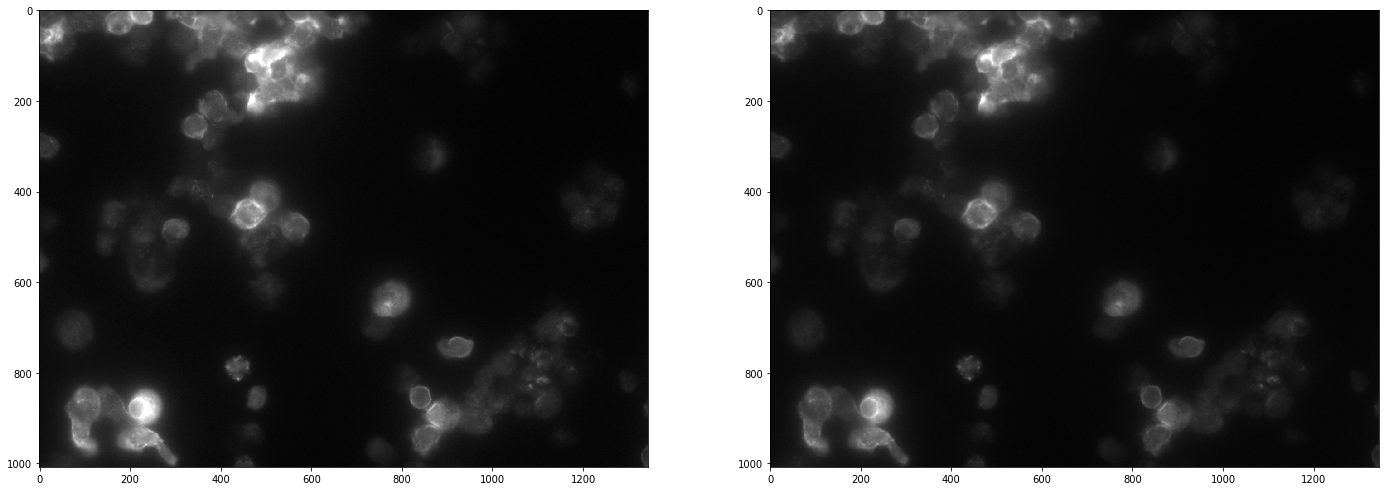

In [10]:
plot_img(img[..., 1:3])

#### Global Unmixing

In [11]:
df.filter(regex='^ci:').shape, df.filter(regex='^ci:').columns

((8460, 3), Index(['ci:DAPI', 'ci:PHA', 'ci:Plasmid'], dtype='object'))

In [12]:
features = df.filter(regex='^ci:').columns.tolist()
#features = ['ci:PHA', 'ci:Plasmid']
features

['ci:DAPI', 'ci:PHA', 'ci:Plasmid']

In [13]:
#df[features].plot(kind='scatter', x=features[0], y=features[1])

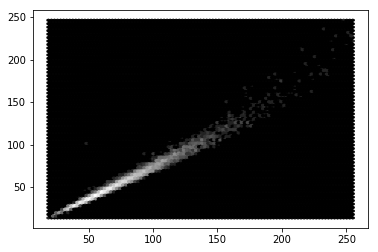

In [14]:
plt.hexbin(df['ci:PHA'], df['ci:Plasmid'], bins='log')

In [199]:
from sklearn.decomposition import NMF


def get_decomposition(df, H=None):
    X = df[features].values
    # See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3832632/
    W = np.random.rand(*X.shape)
    H = H if H is not None else spectral_unmixing.get_default_crosstalk_coefficients(X.shape[1])
    H = H / H.sum(axis=0)
    return NMF(max_iter=1000, init='custom').fit(X, W=W, H=H)

dfm = df
#dfm = df[(df['ci:PHA'] - df['ci:Plasmid']).abs() < 20]
print(len(dfm))
H = np.array([
    [1, 0., 0.],
    [0., 1., .8],
    [0., 0., .2]
])
decomp = get_decomposition(dfm, H=H)

8460


In [200]:
decomp.reconstruction_err_

2.2833717619661416

In [201]:
decomp.n_iter_

912

In [202]:
decomp.components_

array([[0.99974428, 0.03257555, 0.        ],
       [0.        , 1.01311302, 0.68483251],
       [0.01134427, 0.        , 0.70603337]])

In [203]:
pd.DataFrame(decomp.components_, columns=features, index=features)

,ci:DAPI,ci:PHA,ci:Plasmid
ci:DAPI,0.999744,0.032576,0.000000
ci:PHA,0.000000,1.013113,0.684833
ci:Plasmid,0.011344,0.000000,0.706033


In [204]:
pd.DataFrame(decomp.components_, columns=features, index=features).stack().reset_index().iloc[0].to_dict()

{0: 0.9997442767189071, 'level_0': 'ci:DAPI', 'level_1': 'ci:DAPI'}

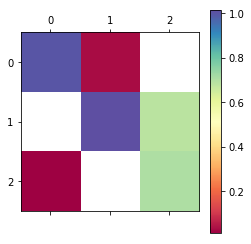

In [205]:
plt.matshow(np.where(decomp.components_ > 0, decomp.components_, np.nan), cmap='Spectral')
plt.colorbar()

In [206]:
def apply_decomposition(decomp, img):
    shape = img.shape
    X = img.reshape((-1, len(features)))
    Y = decomp.transform(X)
    dinfo = np.iinfo(img.dtype)
    return np.clip(Y.reshape(shape), dinfo.min, dinfo.max).astype(img.dtype)

In [207]:
#res = apply_decomposition(decomp, img[..., 2:4])
res = apply_decomposition(decomp, img)

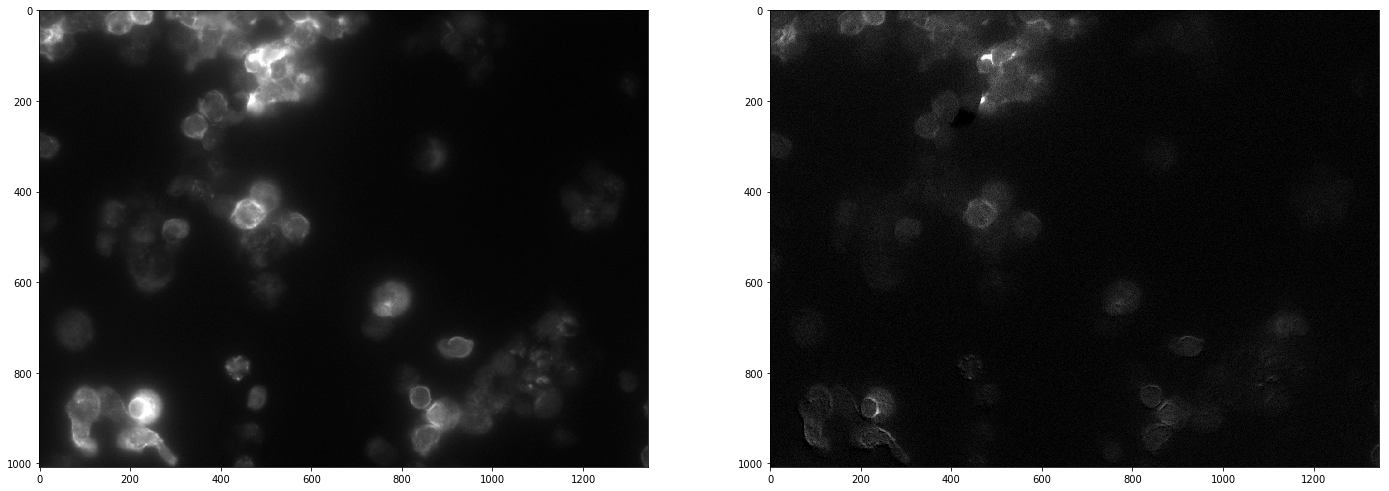

In [208]:
#plot_img(res[..., 2:4], rng=[0, 15])
plot_img(res[..., 1:3], rng=[0, 255])

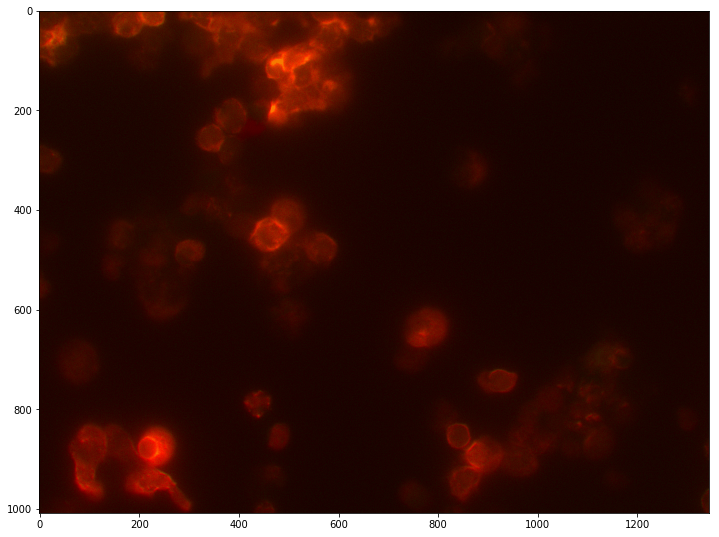

In [209]:
img_rgb = np.zeros(res.shape[:2] + (3,), np.uint8)
img_rgb[..., 0] = res[..., 1]
img_rgb[..., 1] = res[..., 2]
plt.imshow(img_rgb)
plt.gcf().set_size_inches(12, 12)

Text(0.5,1,'Pixel Intensity (After Unmixing)')

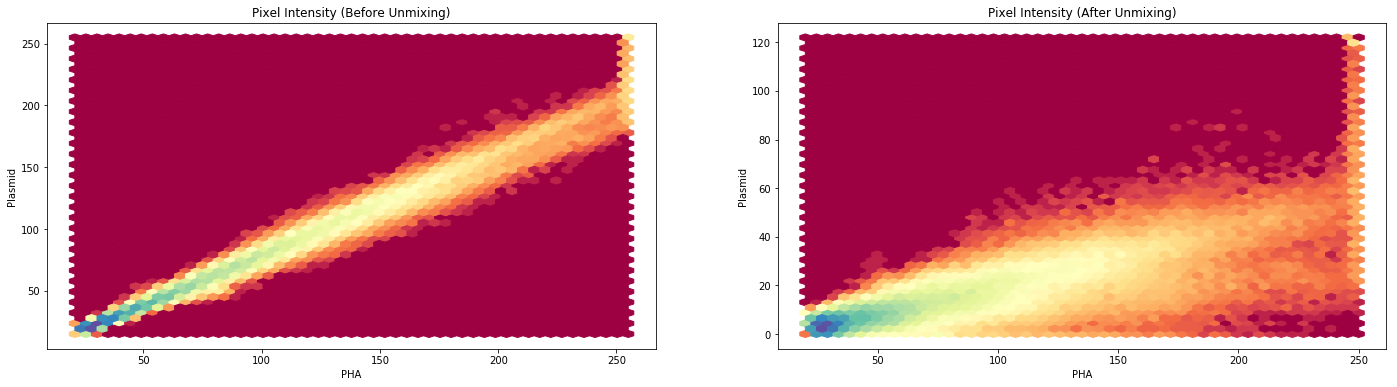

In [210]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].hexbin(img[..., 1].ravel(), img[..., 2].ravel(), bins='log', gridsize=50, cmap='Spectral')
ax[1].hexbin(res[..., 1].ravel(), res[..., 2].ravel(), bins='log', gridsize=50, cmap='Spectral')
ax[0].set_xlabel('PHA')
ax[1].set_xlabel('PHA')
ax[0].set_ylabel('Plasmid')
ax[1].set_ylabel('Plasmid')
ax[0].set_title('Pixel Intensity (Before Unmixing)')
ax[1].set_title('Pixel Intensity (After Unmixing)')

In [48]:
from skimage import filters
#plt.imshow(filters.threshold_otsu(res[..., 3]))
plt.imshow(res[..., 3] > filters.threshold_otsu(res[..., 3]))
plt.gcf().set_size_inches(12, 12)

IndexError: index 3 is out of bounds for axis 2 with size 3

#### Local Unmixing

In [ ]:
from sklearn.decomposition import NMF

def get_unmixed_image(img):
    shape = img.shape
    X = img.reshape((-1, 4))
    decomp = NMF(init='custom', max_iter=1000)
    W = np.random.rand(*X.shape)
    H = (np.eye(X.shape[1], dtype='float') + .25) * (4/5.)
    Y = decomp.fit_transform(X, W=W, H=H)
    return decomp, X.reshape(shape), Y.reshape(shape)

In [ ]:
decomp, X, Y = get_unmixed_image(img)

In [ ]:
decomp.components_

In [135]:
decomp.n_iter_

238

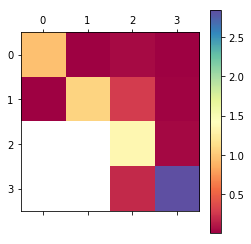

In [136]:
plt.matshow(np.where(decomp.components_ > 0, decomp.components_, np.nan), cmap='Spectral')
plt.colorbar()

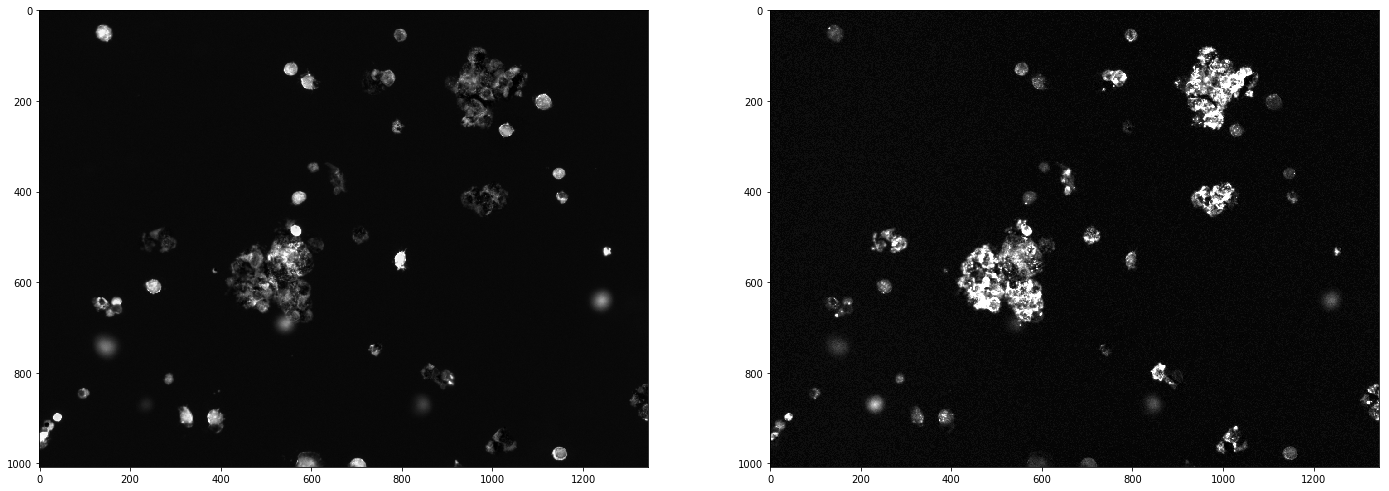

In [137]:
plot_img(Y, rng=[0, 10])

#### Array Reshaping

In [9]:
a = cytokit_io.read_tile('/lab/data/2018-01-09-Run0-Clean/output/v00/processor/tile/R001_X001_Y001.tif')
a.shape

(6, 5, 4, 1008, 1344)

In [11]:
b = a.copy()

In [34]:
def to_rc(a):
    # (ncyc, nz, nch, nh, nw) -> (nz, nh, nw, ncyc, nch)
    a = np.transpose(a, (1, 3, 4, 0, 2))
    
    # (nz, nh, nw, ncyc, nch) -> (nz, nh, nw, C)
    a = np.reshape(a, a.shape[:3] + (-1,))
    
    # (nz, nh, nw, C) -> (R, C)
    return np.reshape(a, (-1, a.shape[-1]))

def from_rc(a, shape):
    # (R, C) -> (nz, nh, nw, C)
    a = np.reshape(a, tuple(shape[i] for i in [1, 3, 4]) + (-1,))
    
    print(a.shape, a.shape[:-1] + (shape[0], shape[2]))
    # (nz, nh, nw, C) -> (nz, nh, nw, ncyc, nch)
    a = np.reshape(a, a.shape[:-1] + (shape[0], shape[2]))
    
    # (nz, nh, nw, ncyc, nch) -> (ncyc, nz, nch, nh, nw)
    return np.transpose(a, (3, 0, 4, 1, 2))


In [35]:
c = to_rc(b)
d = from_rc(c, b.shape)
c.shape, d.shape

(5, 1008, 1344, 24) (5, 1008, 1344, 6, 4)


((6773760, 24), (6, 5, 4, 1008, 1344))

In [36]:
np.array_equal(a, d)

True

In [42]:
from skimage import filters

In [43]:
filters.threshold_otsu(np.ones((3, 3)))

ValueError: threshold_otsu is expected to work with images having more than one color. The input image seems to have just one color 1.0.